# Holt-Winters Exponential Smoothing

This notebook demonstrates running an HWES model in scalecast.

- See the [documentation](https://scalecast.readthedocs.io/en/latest/Forecaster/_forecast.html#module-src.scalecast.Forecaster.Forecaster._forecast_hwes).

In [1]:
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import seaborn as sns
import matplotlib
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from scalecast.Forecaster import Forecaster

Download data from FRED (https://fred.stlouisfed.org/series/HOUSTNSA). This data is interesting due to its strong seasonality and irregular cycles. It measures monthly housing starts in the USA since 1959. Since exponential smoothing generally doesn't need as much data to work effectively, we start the series in 2010, where it has a clear trend and seasonality.

In [2]:
df = pdr.get_data_fred('HOUSTNSA',start='1959-01-01',end='2022-12-31')
f = Forecaster(
    y=df['HOUSTNSA'],
    current_dates=df.index,
    future_dates = 24,
    test_length = 24,
    cis = True,
)
f

Forecaster(
    DateStartActuals=1959-01-01T00:00:00.000000000
    DateEndActuals=2022-12-01T00:00:00.000000000
    Freq=MS
    N_actuals=768
    ForecastLength=24
    Xvars=[]
    TestLength=24
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    CurrentEstimator=mlr
    GridsFile=Grids
)

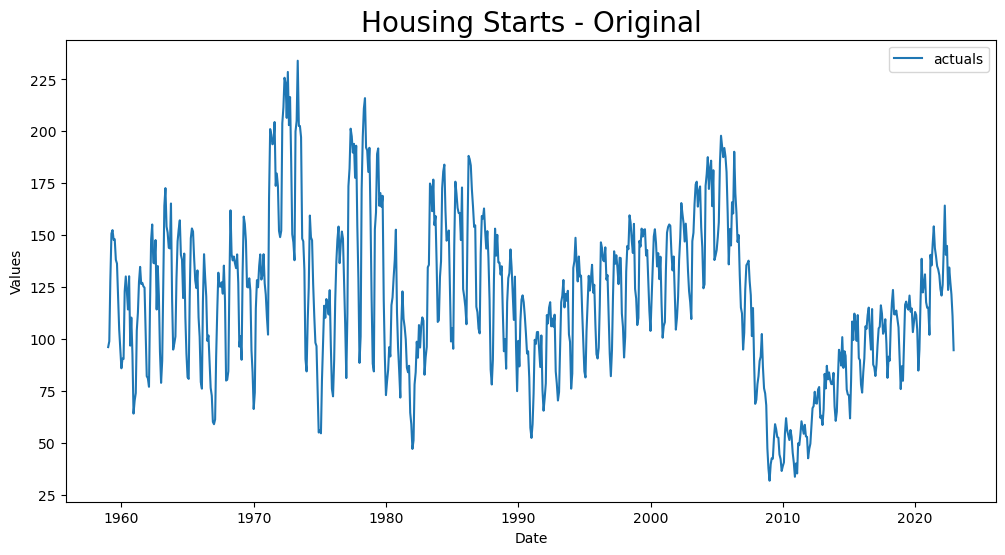

In [3]:
f.plot()
plt.title('Housing Starts - Original',size=20)
plt.show()

## Forecast

In [4]:
hwes_grid = {
    'trend':['add','mul',None],
    'seasonal':['add','mul',None],
    'use_boxcox':[True,False],
}

In [5]:
f.set_estimator('hwes')
f.ingest_grid(hwes_grid)
f.cross_validate(k=10) # 10-fold cv to find optimal hyperparams
f.auto_forecast()
f.best_params

{'trend': None, 'seasonal': 'add', 'use_boxcox': False}

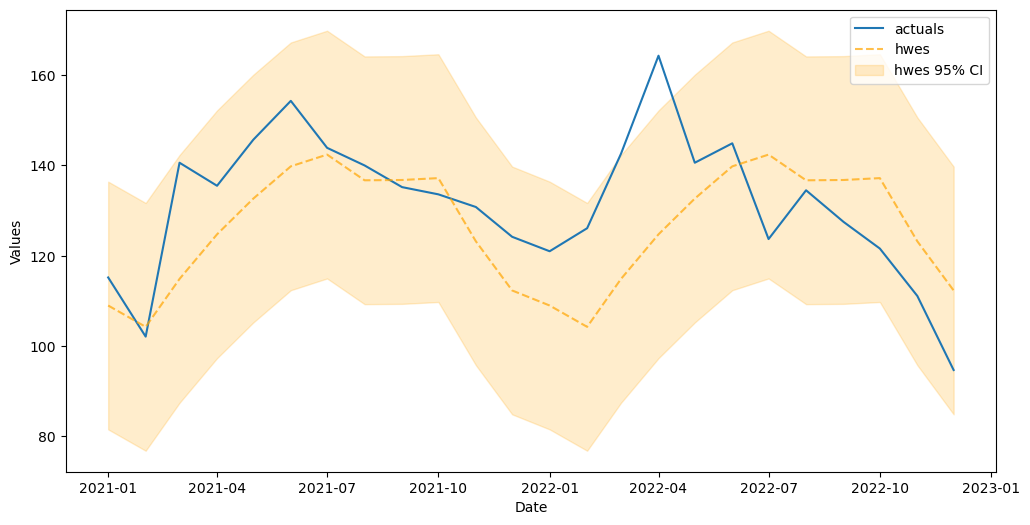

In [6]:
f.plot_test_set(ci=True,include_train=False);

## Model Summary

In [7]:
f.regr.summary()

Dep. Variable:,HOUSTNSA,No. Observations:,768
Model:,ExponentialSmoothing,SSE,91014.035
Optimized:,True,AIC,3695.184
Trend:,None,BIC,3760.197
Seasonal:,Additive,AICC,3695.908
Seasonal Periods:,12,Date:,"Mon, 10 Apr 2023"
Box-Cox:,False,Time:,20:10:11
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.6667527,alpha,True
smoothing_seasonal,0.1106022,gamma,True


## Save Summary Stats

In [8]:
f.save_summary_stats()
f.export_summary_stats('hwes')

,coeff,code,optimized
smoothing_level,0.666753,alpha,True
smoothing_seasonal,0.110602,gamma,True
initial_level,137.889290,l.0,True
initial_seasons.0,-42.836737,s.0,True
initial_seasons.1,-36.976933,s.1,True
initial_seasons.2,-3.359415,s.2,True
initial_seasons.3,22.918534,s.3,True
initial_seasons.4,30.817362,s.4,True
initial_seasons.5,26.588908,s.5,True
initial_seasons.6,20.272506,s.6,True
